## This is the first notebook. Here we try to make the optimal portfolio using the assests in Data\

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import os
import datetime as dt

import pandas_datareader as pdr

sns.set(rc={'figure.figsize':(12,8)})

In [2]:
# data_frames = [ pd.read_csv(os.getcwd()+'\\Data\\'+'AAL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAL"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'AAPL.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "AAPL"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'BAC.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "BAC"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'F.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "F"}),\
#                 pd.read_csv(os.getcwd()+'\\Data\\'+'PFE.csv')[['Date','Adj Close']].rename(columns={"Adj Close": "PFE"})]
# df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
#                             how='outer'), data_frames)
# df_merged['Date'] = pd.to_datetime(df_merged['Date'])
# # df_merged = df_merged.set_index('Date')
# df_merged.head()

In [3]:
### Test automating the asset data retrieval using yfinance library
tickers = ['AAL','AAPL','BAC','F','PFE','MSFT']
start_date = "2021-11-20"
end_date = "2021-11-28"

def fetch_data(tickers=["TSLA","AAPL","MSFT"],start_date = dt.datetime.today()-dt.timedelta(weeks=104),end_date = dt.datetime.today()):
    for i in range(len(tickers)):

        if i == 0:
            res = pdr.get_data_yahoo(tickers[i],start=start_date,end=end_date,)[["Adj Close"]].rename(columns={"Adj Close": tickers[i]}).reset_index()
        else:
            curr = pdr.get_data_yahoo(tickers[i],start=start_date,end=end_date,)[["Adj Close"]].rename(columns={"Adj Close": tickers[i]}).reset_index()
            res = pd.merge(res,curr,on=['Date'],how='outer')
    return res



df_merged = fetch_data(tickers=tickers)

<AxesSubplot:xlabel='Date', ylabel='value'>

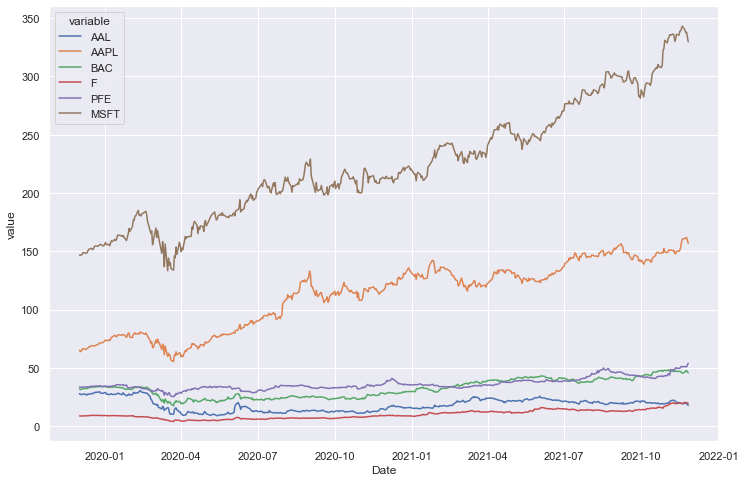

In [4]:
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(df_merged,id_vars='Date'))

In [5]:
# Daily and annual returns
returns_daily = df_merged.set_index("Date").pct_change()
returns_annual = returns_daily.mean() * 250

# Daily and annual covariance of returns
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

<AxesSubplot:xlabel='Date', ylabel='value'>

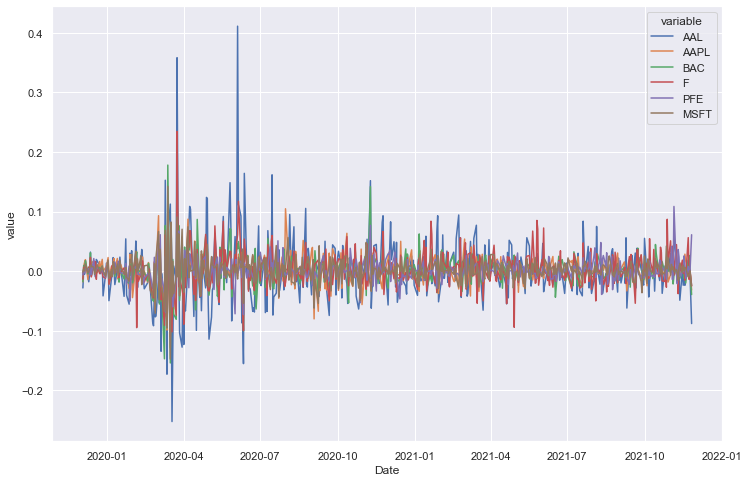

In [6]:
# Daily returns
sns.lineplot(x="Date", y="value",
             hue="variable",
             data=pd.melt(returns_daily.reset_index(), id_vars='Date'))


<AxesSubplot:>

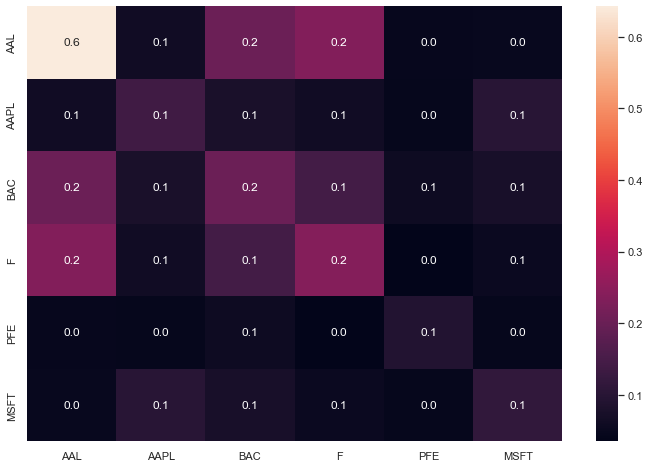

In [7]:
# Covariance matrix
sns.heatmap(cov_annual,annot=True,fmt=".1f")

In [8]:
p_returns = []
p_volatility = []
sharpe_ratios = []
asset_weights = []

# set the number of combinations for imaginary portfolios
n_assets = len(df_merged.columns)-1
n_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

### Simulate different portfolios by giving each asset a random weight. Basically Monte Carlo (MC) method with uniform a priori distribution.

In [9]:
risk_free_rate = 0.01482 # 10 year US bond yield
for i in range(n_portfolios):
    w = np.random.random(n_assets)
    w /= np.sum(w)
    returns = np.dot(w, returns_annual)
    volatility = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    sharpe = (returns-risk_free_rate) / volatility
    sharpe_ratios.append(sharpe)
    p_returns.append(returns)
    p_volatility.append(volatility)
    asset_weights.append(w)

In [10]:
df_w = pd.DataFrame(asset_weights,columns=["Weight: "+ s for s in returns_daily.columns.tolist()])
df_kpi = pd.DataFrame.from_dict({"Returns":p_returns,
"Volatility":p_volatility,
"Sharpe Ratio":sharpe_ratios})
res = pd.concat([df_kpi,df_w],axis=1)
# pd.concat([df_kpi.iloc[0:5,],df_w.iloc[0:5,]],axis=1)
res

,Returns,Volatility,Sharpe Ratio,Weight: AAL,Weight: AAPL,Weight: BAC,Weight: F,Weight: PFE,Weight: MSFT
0,0.358862,0.304076,1.131436,0.184018,0.203357,0.010147,0.061122,0.244198,0.297158
1,0.363955,0.311653,1.120269,0.101698,0.296053,0.239047,0.062927,0.183615,0.116661
2,0.388304,0.331548,1.126482,0.063767,0.275414,0.338476,0.081458,0.029295,0.211590
3,0.308349,0.441394,0.665005,0.304412,0.115351,0.286169,0.216250,0.020246,0.057571
4,0.400342,0.295437,1.304920,0.052556,0.279497,0.146356,0.162695,0.206554,0.152343
...,...,...,...,...,...,...,...,...,...
49995,0.401680,0.352817,1.096490,0.054699,0.087913,0.302839,0.316570,0.037917,0.200062
49996,0.403779,0.322418,1.206381,0.120496,0.114627,0.083638,0.240025,0.090095,0.351118
49997,0.312097,0.364528,0.815511,0.222691,0.053399,0.299966,0.043155,0.086560,0.294229
49998,0.382067,0.317083,1.158207,0.126082,0.204387,0.092582,0.239028,0.212286,0.125635


### Plot the simulated portfolios in the mean-volatility space.

In [13]:
min_volatility_idx = res['Volatility'].argmin()
max_sharpe_idx = res['Sharpe Ratio'].argmax()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = res.loc[max_sharpe_idx]
min_variance_port = res.loc[min_volatility_idx]

In [20]:
    sharpe_portfolio = res.loc[max_sharpe_idx]
    sharpe_html = sharpe_portfolio.to_frame(name="Sharpe portfolio")

    min_variance_port = res.loc[min_volatility_idx]
    var_html = min_variance_port.to_frame(name="Minimum volatility portfolio")

In [24]:
sharpe_html.T.append(var_html.T)

,Returns,Volatility,Sharpe Ratio,Weight: AAL,Weight: AAPL,Weight: BAC,Weight: F,Weight: PFE,Weight: MSFT
0,0.456948,0.291867,1.514831,0.000680,0.251195,0.017638,0.263486,0.156676,0.310325
1,0.381312,0.262324,1.397096,0.019117,0.172019,0.003669,0.149392,0.494498,0.161305


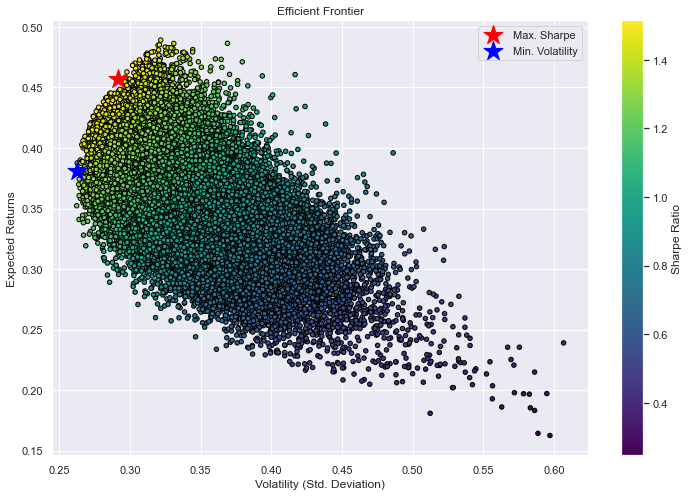

In [47]:
fig, ax = plt.subplots() # Known bug from 2015 onwards, X axis does not show up with pandas+matplotlib when using colourbar
res.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', ax=ax)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

# Find the minimum volatiliy and maximum sharpe portfolios
min_volatility_idx = res['Volatility'].argmin()
max_sharpe_idx = res['Sharpe Ratio'].argmax()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df_kpi.loc[max_sharpe_idx]
min_variance_port = df_kpi.loc[min_volatility_idx]

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='*', s=400,label="Max. Sharpe")
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='*', s=400,label="Min. Volatility")
plt.legend()